In [1]:
import numpy as np
from tqdm import tqdm
import torch
from torchvision.transforms import v2

device = torch.device("cuda:0")

### Cosine similarity as a function of augmentation strength

In [2]:
number_of_hq_samples = 1000
cosine_sim = np.load("/app/model_weights/ms1m_cache/cosine_sim.npy")
labels = np.load("/app/datasets/ms1m/labels.npy")

In [3]:
seen_ids = []
hq_samples = []
cosine_sims = []
sample_count = 0
sorted_sim = np.sort(cosine_sim)[::-1]
id_sorted = np.argsort(cosine_sim)[::-1]
i = 0
while sample_count < number_of_hq_samples:
    sample_id = labels[id_sorted[i]]
    if sample_id not in seen_ids:
        hq_samples.append(id_sorted[i])
        sample_count += 1
        i += 1
        seen_ids.append(sample_id)
        cosine_sims.append(sorted_sim[i])
    else:
        i += 1

In [4]:
from omegaconf import OmegaConf
from face_lib.models.lightning_wrappers import ResNet
from face_lib.models.scf import SphereConfidenceFace, SoftmaxWeights
from face_lib.models.heads import SCFHead

conf = OmegaConf.load("/app/configs/train/train_scf.yaml")
model_trained = torch.load("/app/model_weights/scf_base.ckpt")
backbone = ResNet(
    resnet_name="iresnet50_normalized",
    weights="/app/model_weights/backbone/ms1mv3_arcface_r50/backbone.pth",
    learnable=False,
)
backbone.to(device)
backbone.eval()
softmax_weights = SoftmaxWeights(
    softmax_weights_path="/app/model_weights/backbone/ms1mv3_arcface_r50/softmax_weight.pt",
    radius=64,
).softmax_weights
softmax_weights = torch.nn.functional.normalize(softmax_weights, p=2.0, dim=1)
softmax_weights = softmax_weights.to(device);
# head = SCFHead(25088, 12544)
# scf_model = SphereConfidenceFace(backbone, head, None, None, None, softmax_weights, None)

# scf_model.load_state_dict(model_trained["state_dict"])

/tmp/ipykernel_96243/1443531500.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_trained = torch.load("/app/model_weights/scf_base.ckpt")
/app/face_lib/models/light

In [5]:
from face_lib.dataset_classes.lightning_datasets import MXFaceDataset

ms1m = MXFaceDataset(root_dir="/app/datasets/ms1m/", test=True)

/home/l.erlygin/miniconda/lib/python3.9/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [6]:
transform = v2.Compose(
    [
        v2.ToPILImage(),
        v2.ToTensor(),
        v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ]
)

In [7]:
import matplotlib.pyplot as plt
from torchvision.transforms.v2 import GaussianNoise, GaussianBlur

sigmas = [0.1, 1, 2, 3, 4, 5, 8, 10, 12]
kerner_size = 11
cosine_similarities = []
for sigma in sigmas:
    cos_sim = []
    transform_blur = v2.Compose(
        [
            v2.ToPILImage(),
            v2.ToTensor(),
            v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
            GaussianBlur(kernel_size=kerner_size, sigma=sigma),
        ]
    )
    for image_id in tqdm(range(number_of_hq_samples)):
        image = transform_blur(ms1m[hq_samples[image_id]]).to(device)
        features = backbone(image[None, ...])["feature"][0, :]
        cos_sim.append((features @ softmax_weights[seen_ids[image_id]]).item())
    cosine_similarities.append(cos_sim)
# GaussianNoise(mean=0.3, sigma=0.5),
# GaussianBlur(kernel_size=5, sigma=(1, 5)),

# image = (transform_blur(ms1m[hq_samples[-1]]) + 0.5) * 0.5
# plt.imshow(image.permute(1, 2, 0))

  0%|          | 0/1000 [00:00<?, ?it/s]/app/face_lib/models/iresnet.py:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.fp16):
100%|██████████| 1000/1000 [00:10<00:00, 93.28it/s]


In [8]:
cosine_similarities = np.array(cosine_similarities)

<AxesSubplot:ylabel='Count'>

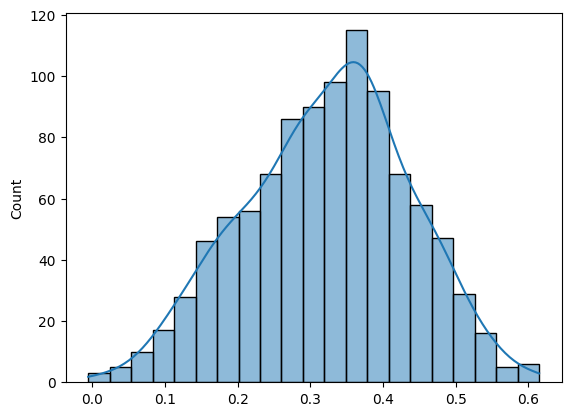

In [9]:
import seaborn as sns

x = cosine_similarities[-2]
np.random.shuffle(x)
sns.histplot(x, kde=True, hue_norm=True)

Text(0, 0.5, 'Cosine similarity')

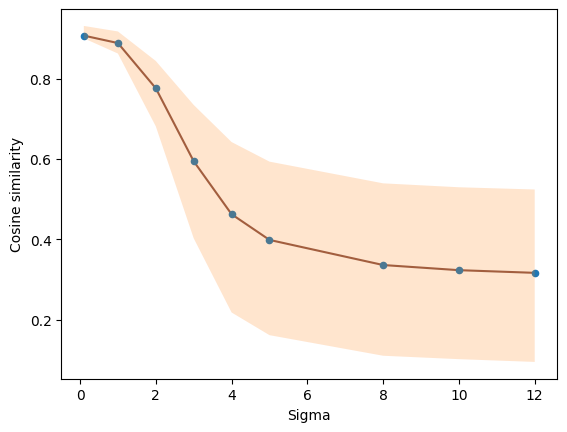

In [16]:
fig, ax = plt.subplots()
mean = np.mean(cosine_similarities, axis=1)
std = np.std(cosine_similarities, axis=1)
alpha = 0.05
high_quantile = np.quantile(cosine_similarities, 1 - alpha / 2, axis=1)
low_quantile = -np.quantile(-cosine_similarities, 1 - alpha / 2, axis=1)
ax.plot(sigmas, mean, color="tab:brown", zorder=-1)
ax.scatter(sigmas, mean, s=20)
ax.fill_between(sigmas, low_quantile, high_quantile, alpha=0.2)
ax.set_xlabel("Sigma")
ax.set_ylabel("Cosine similarity")
# ax.fill_between(sigmas, mean - 1.96*std, mean + 1.96*std, alpha=0.2)

In [11]:
np.array(sigmas).dtype

dtype('float64')

In [12]:
cosine_similarities

array([[0.99316454, 0.99298769, 0.96350849, ..., 0.90060294, 0.90061486,
        0.9006176 ],
       [0.96776617, 0.96735513, 0.94894123, ..., 0.89131188, 0.8721469 ,
        0.87733305],
       [0.83051127, 0.83059818, 0.87140167, ..., 0.7933594 , 0.74477327,
        0.79327762],
       ...,
       [0.52805364, 0.53028852, 0.48443165, ..., 0.34349382, 0.31126243,
        0.40894675],
       [0.48941398, 0.54085428, 0.36702168, ..., 0.23363081, 0.37807602,
        0.32268274],
       [0.51780689, 0.51956993, 0.45769146, ..., 0.32246369, 0.28704467,
        0.38881385]])

In [13]:
softmax_weights.device

device(type='cuda', index=0)

In [14]:
features = backbone(image[None, ...])["feature"][0, :]

/app/face_lib/models/iresnet.py:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.fp16):


In [15]:
cosine_sims[-1]

0.9006073